# Import libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')

from statsmodels.tsa.stattools import adfuller  # kiểm tra chuỗi có tính dừng không -> có phụ thuộc vào thời gian chạy không?
from statsmodels.tsa.seasonal import seasonal_decompose   # phân tích -> thành phần chuỗi gốc, thành phần xu hướng, thành phần mùa vụ và thành phần nhiễu

from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential

# Eval Function - 3 Model Evaluation: MAPE (old), RMSE(old), MDA(new)

In [2]:
# Hàm tính MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

def eval(test,pred):
  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

  test_mda = calculate_mda(test, pred)
  print('MDE: ', test_mda)

In [3]:
def test_stationarity(timeseries):

    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='yellow', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC') # tự động lựa chọn số lượng lag tối ưu dựa trên tiêu chí AIC ->
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

In [4]:
def train_test(data):
    test_size = 0.15  # Thay đổi test_size thành 0.15 để có tỉ lệ 8.5:1.5

    test_split_idx = int(data.shape[0] * (1 - test_size))

    return data[:test_split_idx], data[test_split_idx:]

# ACB


## Data

In [5]:
df_amz = pd.read_csv("ACB Historical Data.csv")
df_amz

,Date,Price,Open,High,Low,Vol.,Change %
0,12/1/2017,"10,537.70","10,477.80","10,567.60","10,417.90",7.36M,0.86%
1,12/4/2017,"10,926.90","10,537.70","10,956.80","10,537.70",9.45M,3.69%
2,12/5/2017,"10,477.80","10,956.80","10,956.80","10,477.80",8.19M,-4.11%
3,12/6/2017,"10,447.90","10,447.90","10,627.50","10,328.10",9.81M,-0.29%
4,12/7/2017,"10,837.10","10,447.90","10,837.10","10,447.90",8.30M,3.73%
...,...,...,...,...,...,...,...
1506,12/18/2023,"22,800.00","22,700.00","22,800.00","22,650.00",6.39M,0.22%
1507,12/19/2023,"23,050.00","22,800.00","23,100.00","22,800.00",11.47M,1.10%
1508,12/20/2023,"23,200.00","23,050.00","23,250.00","23,050.00",8.86M,0.65%
1509,12/21/2023,"23,250.00","23,200.00","23,250.00","23,050.00",7.08M,0.22%


## Preprocessing

### Check null and na value

In [6]:
df_amz.isnull().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64

In [7]:
df_amz.isna().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64

### Check datatype of each column

In [8]:
# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)
    
# Áp dụng hàm chuyển đổi cho cột "Vol."
df_amz["Vol."] = df_amz["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
df_amz["Change %"] = df_amz["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
df_amz['Price'] = df_amz['Price'].apply(convert_str_to_number)
df_amz['Open'] = df_amz['Open'].apply(convert_str_to_number)
df_amz['High'] = df_amz['High'].apply(convert_str_to_number)
df_amz['Low'] = df_amz['Low'].apply(convert_str_to_number)

In [9]:
print("Date column data type: ", type(df_amz['Date'][0]))
print("Open column data type: ", type(df_amz['Open'][0]))
print("Price column data type: ", type(df_amz['Price'][0]))
print("High column data type: ", type(df_amz['High'][0]))
print("Low column data type: ", type(df_amz['Low'][0]))
print("Vol. column data type: ", type(df_amz['Vol.'][0]))
print("Volume column data type: ", type(df_amz['Low'][0]))

Date column data type:  <class 'str'>
Open column data type:  <class 'numpy.float64'>
Price column data type:  <class 'numpy.float64'>
High column data type:  <class 'numpy.float64'>
Low column data type:  <class 'numpy.float64'>
Vol. column data type:  <class 'numpy.int64'>
Volume column data type:  <class 'numpy.float64'>


### Convert date from string to date format

In [10]:
df_amz['Date'] = pd.to_datetime(df_amz.Date)

### Choose X

In [11]:
close_amz=df_amz[['Price']]

## EDA

### Get the duration of dataset

In [12]:
print("Starting date: ",df_amz.iloc[0][0])
print("Ending date: ", df_amz.iloc[-1][0])
print("Duration: ", df_amz.iloc[-1][0]-df_amz.iloc[0][0])

Starting date:  2017-12-01 00:00:00
Ending date:  2023-12-22 00:00:00
Duration:  2212 days 00:00:00


### Visualize the per day closing price of the stock

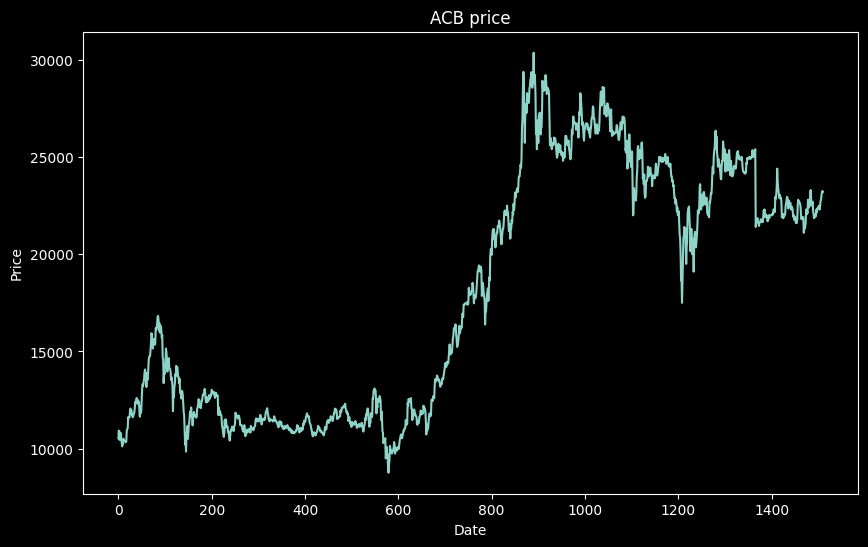

In [13]:
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(close_amz)
plt.title('ACB price')
plt.show()

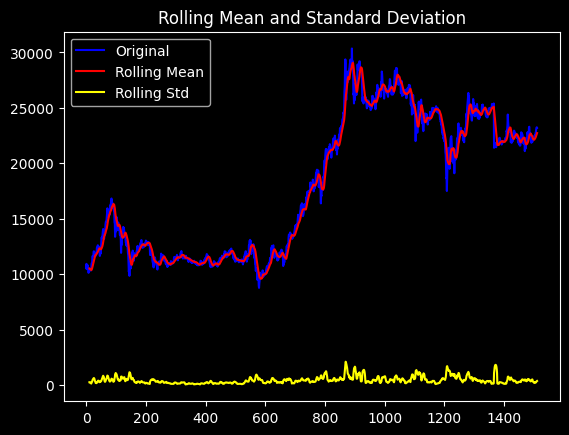

Results of dickey fuller test
Test Statistics                  -1.291961
p-value                           0.632842
No. of lags used                  3.000000
Number of observations used    1507.000000
critical value (1%)              -3.434697
critical value (5%)              -2.863460
critical value (10%)             -2.567792
dtype: float64


In [14]:
test_stationarity(close_amz)

## Train, test

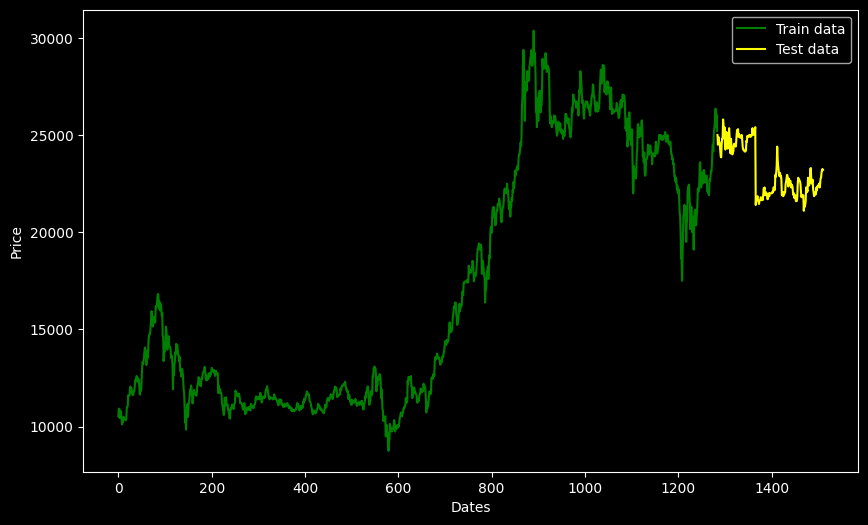

In [15]:
close_amz = close_amz.reset_index(drop=True)

#train_data, test_data, valid_data = train_test_valid(close_amz)
train_data, test_data = train_test(close_amz)

plt.figure(figsize=(10,6))
plt.xlabel('Dates')
plt.ylabel('Price')
plt.plot(train_data, 'green', label='Train data')
#plt.plot(valid_data, 'yellow', label='Valid data')
plt.plot(test_data, 'yellow', label='Test data')
plt.legend()

In [16]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

## Build model

### Choose p, q, d

In [17]:
model_autoARIMA = auto_arima(y_train,start_p=0, start_q=0,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=False,
                           d=0, D=0, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True,
                      exogenous= df_amz[['High','Open','Low']][:len(y_train)])

model_autoARIMA.summary()

C:\Users\20520\AppData\Local\Programs\Python\Python37\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=28844.879, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=18908.514, Time=0.16 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=18905.096, Time=0.20 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=18906.953, Time=0.38 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=18906.957, Time=0.33 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=18908.910, Time=0.30 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.62 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=18904.314, Time=0.30 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=18907.654, Time=0.30 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=18906.168, Ti

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1284
Model:               SARIMAX(2, 0, 1)   Log Likelihood               -9447.157
Date:                Sat, 23 Dec 2023   AIC                          18904.314
Time:                        11:57:30   BIC                          18930.102
Sample:                             0   HQIC                         18913.996
                               - 1284                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     39.0654     65.561      0.596      0.551     -89.432     167.563
ar.L1          0.0572      0.049      1.176      0.240      -0.038       0.153
ar.L2          0.9405      0.049     19.331      0.000       0.845       1.036
ma.L1          0.9187      0.056     16.440      0.000       0.809       1.028
sigma2      1.437e+05   3206.328     44.802      0.000    1.37e+05     1.5e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):              1063.55
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               4.13   Skew:                            -0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Build model

In [18]:
model = ARIMA(y_train, order=(1,0,1),exog=df_amz[['High','Open','Low']][:len(y_train)]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1284
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -8398.374
Date:                Sat, 23 Dec 2023   AIC                          16810.748
Time:                        11:57:31   BIC                          16846.852
Sample:                             0   HQIC                         16824.303
                               - 1284                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.7938     16.772     -0.226      0.821     -36.665      29.078
High           0.8486      0.011     76.317      0.000       0.827       0.870
Open          -0.6275      0.014    -44.427      0.000      -0.655      -0.600
Low            0.7782      0.011     68.417      0.000       0.756       0.800
ar.L1         -0.6225      0.125     -5.000      0.000      -0.867      -0.379
ma.L1          0.5350      0.135      3.958      0.000       0.270       0.800
sigma2      2.812e+04    577.602     48.682      0.000     2.7e+04    2.93e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.63   Jarque-Bera (JB):              2488.05
Prob(Q):                              0.43   Prob(JB):                         0.00
Heteroskedasticity (H):               2.39   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Eval

In [19]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(start=int(x_test[0]), end=int(len(x_test)+x_test[0]-1),exog=df_amz[['High','Open','Low']][int(x_test[0]):int(len(x_test)+x_test[0])])

In [20]:
eval(y_test,y_pred)

MAPE:  0.4290575539830154
RMSE:  127.79853149586206
MDE:  64.15929203539822


## Forecast

In [21]:
last_index =  close_amz.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

y_next_30_days = model.predict(start=int(x_next_30_days[0]), end=int(len(x_next_30_days)+x_next_30_days[0]-1),exog=df_amz[['High','Open','Low']][last_index-257:last_index])

print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
1511    22434.079023
1512    22363.793895
1513    22812.929954
1514    23366.079152
1515    23241.074557
1516    22718.936636
1517    22653.273608
1518    22641.479536
1519    22576.442272
1520    22334.212077
1521    21892.051317
1522    21918.112707
1523    21895.506189
1524    22278.372197
1525    22165.656324
1526    21819.973196
1527    22331.858877
1528    22213.895140
1529    22141.817019
1530    22373.056837
1531    22430.558595
1532    22317.842721
1533    22356.753038
1534    22367.808973
1535    22600.281577
1536    22754.195410
1537    22726.835676
1538    23035.401479
1539    23200.371247
1540    23106.246814
Name: predicted_mean, dtype: float64


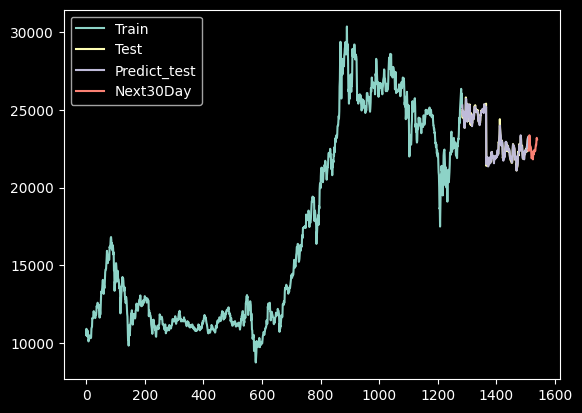

In [22]:
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predict_test','Next30Day'])
plt.show()

# PVS

## Data

In [23]:
df_PVS = pd.read_csv("PVS Historical Data.csv")
df_PVS

,Date,Price,Open,High,Low,Vol.,Change %
0,12/1/2017,"17,292.00","16,746.00","17,474.00","16,655.00",12.03M,4.40%
1,12/4/2017,"17,838.00","17,383.00","17,838.00","17,383.00",6.60M,3.16%
2,12/5/2017,"17,292.00","18,020.00","18,020.00","17,292.00",6.46M,-3.06%
3,12/6/2017,"17,565.00","17,201.00","17,656.00","16,837.00",8.73M,1.58%
4,12/7/2017,"17,110.00","17,383.00","17,474.00","17,019.00",6.10M,-2.59%
...,...,...,...,...,...,...,...
1511,12/18/2023,"37,400.00","37,500.00","38,000.00","37,400.00",1.84M,-0.27%
1512,12/19/2023,"37,900.00","37,600.00","37,900.00","37,100.00",2.54M,1.34%
1513,12/20/2023,"38,400.00","37,900.00","38,600.00","37,900.00",3.04M,1.32%
1514,12/21/2023,"38,200.00","37,400.00","38,700.00","37,400.00",1.44M,-0.52%


## Preprocessing

### Check null and na value

In [24]:
df_PVS.isnull().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64

In [25]:
df_PVS.isna().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64

### Check datatype of each column

In [26]:
# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)
    
# Áp dụng hàm chuyển đổi cho cột "Vol."
df_PVS["Vol."] = df_PVS["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
df_PVS["Change %"] = df_PVS["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
df_PVS['Price'] = df_PVS['Price'].apply(convert_str_to_number)
df_PVS['Open'] = df_PVS['Open'].apply(convert_str_to_number)
df_PVS['High'] = df_PVS['High'].apply(convert_str_to_number)
df_PVS['Low'] = df_PVS['Low'].apply(convert_str_to_number)

In [27]:
print("Date column data type: ", type(df_PVS['Date'][0]))
print("Open column data type: ", type(df_PVS['Open'][0]))
print("Price column data type: ", type(df_PVS['Price'][0]))
print("High column data type: ", type(df_PVS['High'][0]))
print("Low column data type: ", type(df_PVS['Low'][0]))
print("Vol. column data type: ", type(df_PVS['Vol.'][0]))
print("Volume column data type: ", type(df_PVS['Low'][0]))

Date column data type:  <class 'str'>
Open column data type:  <class 'numpy.float64'>
Price column data type:  <class 'numpy.float64'>
High column data type:  <class 'numpy.float64'>
Low column data type:  <class 'numpy.float64'>
Vol. column data type:  <class 'numpy.int64'>
Volume column data type:  <class 'numpy.float64'>


### Convert date from string to date format

In [28]:
df_PVS['Date'] = pd.to_datetime(df_PVS.Date)

### Choose X

In [29]:
close_PVS=df_PVS[['Price']]

## EDA

### Get the duration of dataset

In [30]:
print("Starting date: ",df_PVS.iloc[0][0])
print("Ending date: ", df_PVS.iloc[-1][0])
print("Duration: ", df_PVS.iloc[-1][0]-df_PVS.iloc[0][0])

Starting date:  2017-12-01 00:00:00
Ending date:  2023-12-22 00:00:00
Duration:  2212 days 00:00:00


### Visualize the per day closing price of the stock

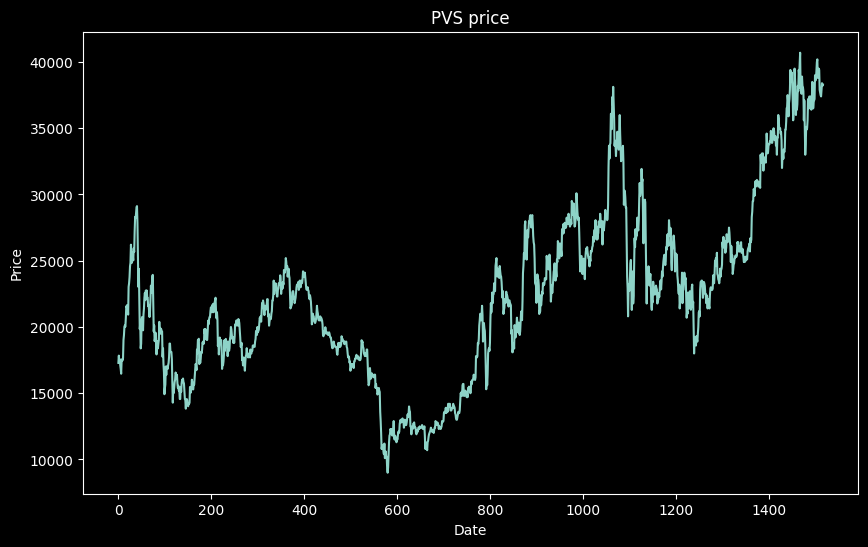

In [31]:
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(close_PVS)
plt.title('PVS price')
plt.show()

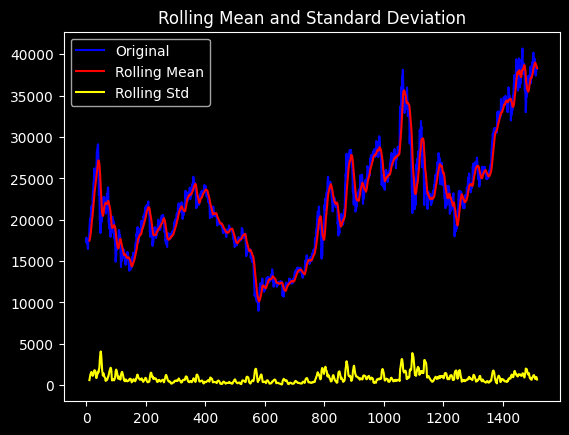

Results of dickey fuller test
Test Statistics                  -1.541720
p-value                           0.512781
No. of lags used                  0.000000
Number of observations used    1515.000000
critical value (1%)              -3.434674
critical value (5%)              -2.863450
critical value (10%)             -2.567787
dtype: float64


In [32]:
test_stationarity(close_PVS)

## Train, test

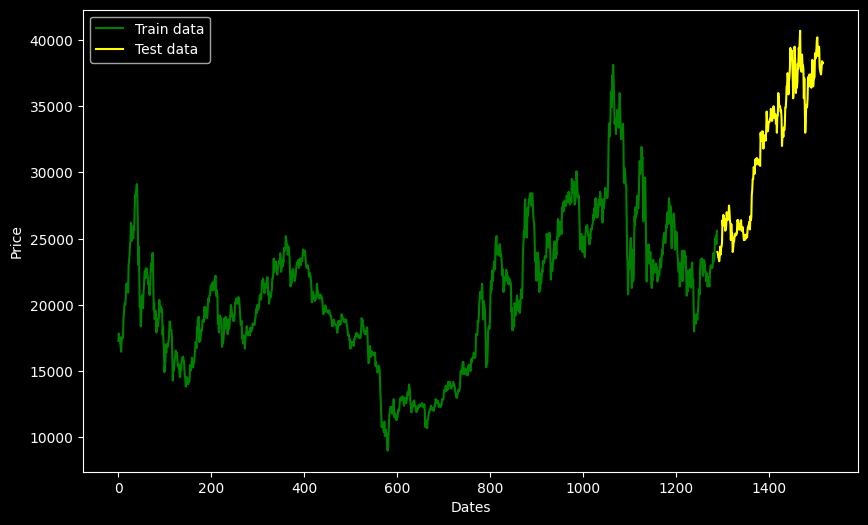

In [33]:
close_PVS = close_PVS.reset_index(drop=True)

train_data, test_data= train_test(close_PVS)

plt.figure(figsize=(10,6))
plt.xlabel('Dates')
plt.ylabel('Price')
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'yellow', label='Test data')
plt.legend()

In [34]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

## Build model

### Choose p, q, d

In [35]:
model_autoARIMA = auto_arima(y_train,start_p=0, start_q=0,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=False,
                           d=0, D=0, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True,
                      exogenous= df_PVS[['High','Open','Low']][:len(y_train)])

model_autoARIMA.summary()

C:\Users\20520\AppData\Local\Programs\Python\Python37\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=29324.652, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=20608.862, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=20606.717, Time=0.20 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=20611.570, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=20608.088, Time=0.57 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=20610.149, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=20610.655, Time=0.24 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=20601.344, Time=0.39 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=20601.458, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=20604.8

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1288
Model:               SARIMAX(2, 0, 1)   Log Likelihood              -10295.672
Date:                Sat, 23 Dec 2023   AIC                          20601.344
Time:                        11:57:35   BIC                          20627.148
Sample:                             0   HQIC                         20611.030
                               - 1288                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    198.0442    180.287      1.098      0.272    -155.312     551.400
ar.L1          0.0800      0.061      1.305      0.192      -0.040       0.200
ar.L2          0.9100      0.061     14.945      0.000       0.791       1.029
ma.L1          0.9372      0.053     17.643      0.000       0.833       1.041
sigma2      5.135e+05   1.38e+04     37.262      0.000    4.86e+05    5.41e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.44   Jarque-Bera (JB):               373.47
Prob(Q):                              0.51   Prob(JB):                         0.00
Heteroskedasticity (H):               2.17   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Build model

In [36]:
model = ARIMA(y_train, order=(3,0,2),exog=df_PVS[['High','Open','Low']][:len(y_train)]).fit()
model.summary()

C:\Users\20520\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\20520\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1288
Model:                 ARIMA(3, 0, 2)   Log Likelihood               -9318.247
Date:                Sat, 23 Dec 2023   AIC                          18656.495
Time:                        11:57:36   BIC                          18708.103
Sample:                             0   HQIC                         18675.867
                               - 1288                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        124.1285     38.801      3.199      0.001      48.080     200.177
High           0.7990      0.013     62.735      0.000       0.774       0.824
Open          -0.5698      0.014    -41.472      0.000      -0.597      -0.543
Low            0.7612      0.014     53.111      0.000       0.733       0.789
ar.L1         -0.0732      0.972     -0.075      0.940      -1.979       1.832
ar.L2          0.0041      1.003      0.004      0.997      -1.961       1.969
ar.L3          0.0236      0.143      0.164      0.869      -0.258       0.305
ma.L1         -0.0744      0.975     -0.076      0.939      -1.985       1.836
ma.L2          0.0028      0.955      0.003      0.998      -1.870       1.875
sigma2      1.121e+05   2779.265     40.344      0.000    1.07e+05    1.18e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1061.58
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               2.39   Skew:                             0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Eval

In [37]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(start=int(x_test[0]), end=int(len(x_test)+x_test[0]-1),exog=df_PVS[['High','Open','Low']][int(x_test[0]):int(len(x_test)+x_test[0])])

In [38]:
eval(y_test,y_pred)

MAPE:  0.9975529167849174
RMSE:  418.05414049726755
MDE:  61.23348017621145


## Forecast

In [39]:
last_index =  close_PVS.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

y_next_30_days = model.predict(start=int(x_next_30_days[0]), end=int(len(x_next_30_days)+x_next_30_days[0]-1),exog=df_PVS[['High','Open','Low']][last_index-258:last_index])

print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
1516    36644.145161
1517    36839.745038
1518    37537.220375
1519    37323.783399
1520    36840.178959
1521    36364.744857
1522    36116.191829
1523    37583.792663
1524    37960.498734
1525    37404.479670
1526    36371.683866
1527    37118.153274
1528    36802.335156
1529    38743.076261
1530    39003.647397
1531    38843.415749
1532    39331.049703
1533    40450.067716
1534    39244.827495
1535    38643.228211
1536    38588.791554
1537    38996.092724
1538    38657.412199
1539    37797.721078
1540    37872.611276
1541    37731.518489
1542    37586.648366
1543    37221.402257
1544    38218.718523
1545    38202.923077
Name: predicted_mean, dtype: float64


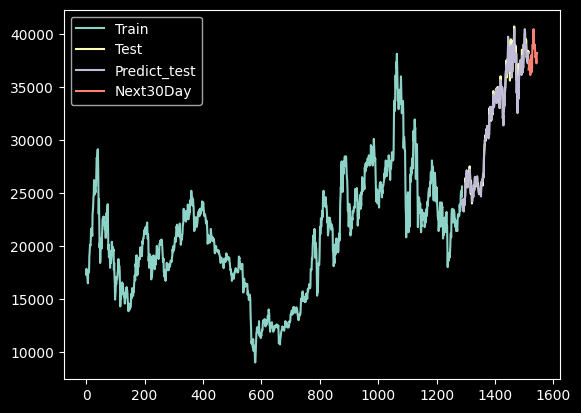

In [40]:
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predict_test','Next30Day'])
plt.show()

# VNM

## Data

In [41]:
df_VNM = pd.read_csv("VNM Historical Data.csv")
df_VNM

,Date,Price,Open,High,Low,Vol.,Change %
0,12/1/2017,"159,039.00","151,736.00","159,039.00","151,736.00",1.50M,4.98%
1,12/4/2017,"164,719.00","159,039.00","166,423.00","159,039.00",1.70M,3.57%
2,12/5/2017,"161,473.00","164,719.00","166,342.00","160,662.00",852.08K,-1.97%
3,12/6/2017,"158,227.00","158,227.00","159,850.00","151,898.00",1.14M,-2.01%
4,12/7/2017,"150,924.00","158,227.00","160,580.00","150,924.00",1.43M,-4.62%
...,...,...,...,...,...,...,...
1509,12/18/2023,"67,000.00","68,100.00","68,200.00","67,000.00",3.51M,-1.62%
1510,12/19/2023,"67,000.00","67,100.00","67,400.00","66,300.00",3.06M,0.00%
1511,12/20/2023,"68,100.00","67,000.00","68,200.00","67,000.00",2.60M,1.64%
1512,12/21/2023,"67,800.00","67,900.00","68,300.00","67,800.00",2.59M,-0.44%


## Preprocessing

### Check null and na value

In [42]:
df_VNM.isnull().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64

In [43]:
df_VNM.isna().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64

### Check datatype of each column

In [44]:
# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)
    
# Áp dụng hàm chuyển đổi cho cột "Vol."
df_VNM["Vol."] = df_VNM["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
df_VNM["Change %"] = df_VNM["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
df_VNM['Price'] = df_VNM['Price'].apply(convert_str_to_number)
df_VNM['Open'] = df_VNM['Open'].apply(convert_str_to_number)
df_VNM['High'] = df_VNM['High'].apply(convert_str_to_number)
df_VNM['Low'] = df_VNM['Low'].apply(convert_str_to_number)

In [45]:
print("Date column data type: ", type(df_VNM['Date'][0]))
print("Open column data type: ", type(df_VNM['Open'][0]))
print("Price column data type: ", type(df_VNM['Price'][0]))
print("High column data type: ", type(df_VNM['High'][0]))
print("Low column data type: ", type(df_VNM['Low'][0]))
print("Vol. column data type: ", type(df_VNM['Vol.'][0]))
print("Volume column data type: ", type(df_VNM['Low'][0]))

Date column data type:  <class 'str'>
Open column data type:  <class 'numpy.float64'>
Price column data type:  <class 'numpy.float64'>
High column data type:  <class 'numpy.float64'>
Low column data type:  <class 'numpy.float64'>
Vol. column data type:  <class 'numpy.int64'>
Volume column data type:  <class 'numpy.float64'>


### Convert date from string to date format

In [46]:
df_VNM['Date'] = pd.to_datetime(df_VNM.Date)

### Choose X

In [47]:
close_VNM=df_VNM[['Price']]

## EDA

### Get the duration of dataset

In [48]:
print("Starting date: ",df_VNM.iloc[0][0])
print("Ending date: ", df_VNM.iloc[-1][0])
print("Duration: ", df_VNM.iloc[-1][0]-df_VNM.iloc[0][0])

Starting date:  2017-12-01 00:00:00
Ending date:  2023-12-22 00:00:00
Duration:  2212 days 00:00:00


### Visualize the per day closing price of the stock

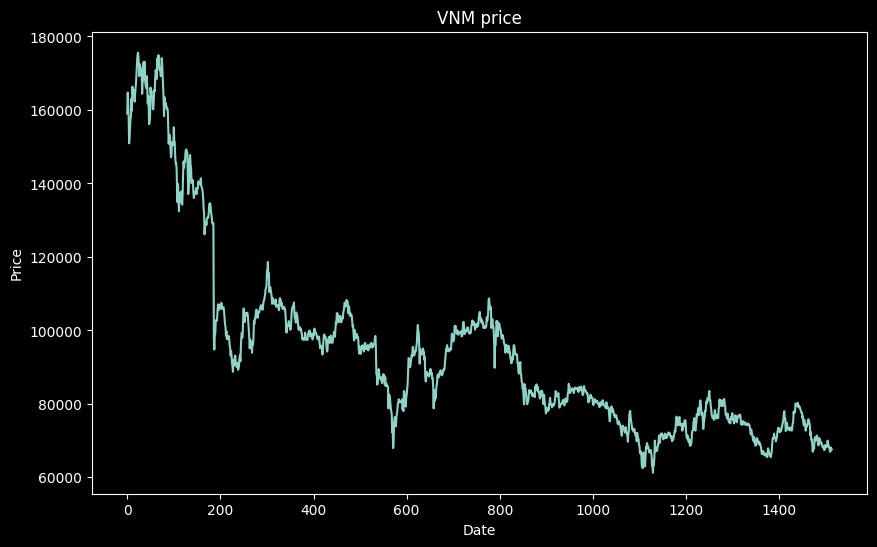

In [49]:
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(close_VNM)
plt.title('VNM price')
plt.show()

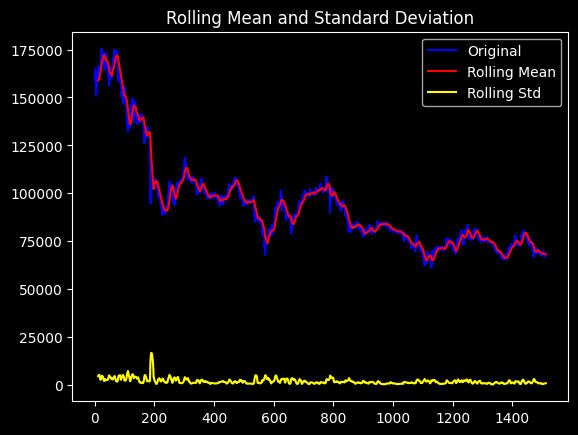

Results of dickey fuller test
Test Statistics                  -2.360615
p-value                           0.153162
No. of lags used                  0.000000
Number of observations used    1513.000000
critical value (1%)              -3.434679
critical value (5%)              -2.863452
critical value (10%)             -2.567788
dtype: float64


In [50]:
test_stationarity(close_VNM)

## Train, test

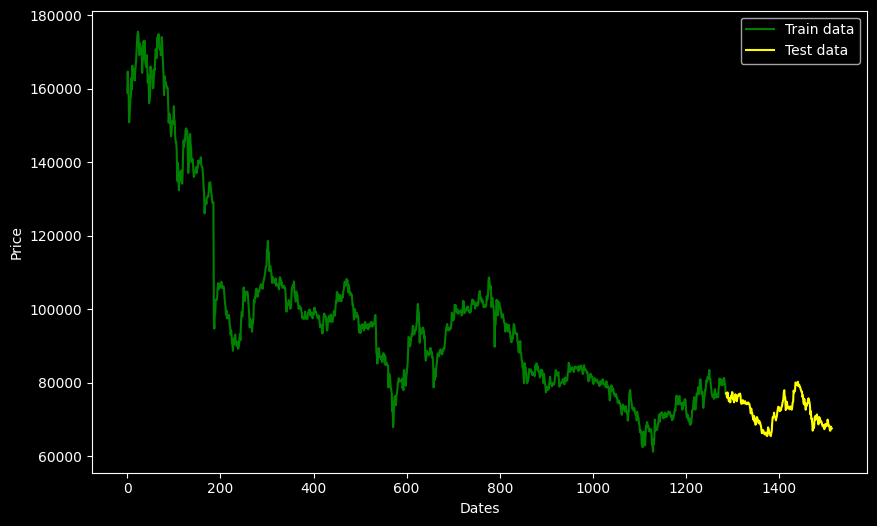

In [51]:
close_VNM = close_VNM.reset_index(drop=True)

train_data, test_data = train_test(close_VNM)

plt.figure(figsize=(10,6))
plt.xlabel('Dates')
plt.ylabel('Price')
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'yellow', label='Test data')
plt.legend()

In [52]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

## Build model

### Choose p, q, d

In [53]:
model_autoARIMA = auto_arima(y_train,start_p=0, start_q=0,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=False,
                           d=0, D=0, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True,
                      exogenous= df_VNM[['High','Open','Low']][:len(y_train)])

model_autoARIMA.summary()

C:\Users\20520\AppData\Local\Programs\Python\Python37\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=33299.985, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=23028.043, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=23027.315, Time=0.35 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=23029.518, Time=0.21 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=23031.550, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=23030.297, Time=0.16 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=23028.316, Time=0.37 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=23026.209, Time=0.54 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=23028.680, Time=0.13 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=23027.9

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1286
Model:               SARIMAX(2, 0, 1)   Log Likelihood              -11508.105
Date:                Sat, 23 Dec 2023   AIC                          23026.209
Time:                        11:57:42   BIC                          23052.006
Sample:                             0   HQIC                         23035.894
                               - 1286                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    408.0335    397.421      1.027      0.305    -370.898    1186.965
ar.L1          0.0382      0.045      0.857      0.392      -0.049       0.126
ar.L2          0.9580      0.045     21.482      0.000       0.871       1.045
ma.L1          0.9460      0.052     18.227      0.000       0.844       1.048
sigma2      3.414e+06      0.462   7.39e+06      0.000    3.41e+06    3.41e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):            236570.52
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               0.19   Skew:                            -3.74
Prob(H) (two-sided):                  0.00   Kurtosis:                        69.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.89e+21. Standard errors may be unstable.
"""

### Build model

In [54]:
model = ARIMA(y_train, order=(1,0,1),exog=df_VNM[['High','Open','Low']][:len(y_train)]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1286
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -10099.461
Date:                Sat, 23 Dec 2023   AIC                          20212.923
Time:                        11:57:42   BIC                          20249.038
Sample:                             0   HQIC                         20226.481
                               - 1286                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -118.5600     57.766     -2.052      0.040    -231.779      -5.341
High           0.8102      0.011     70.944      0.000       0.788       0.833
Open          -0.6070      0.013    -48.484      0.000      -0.632      -0.583
Low            0.7974      0.011     74.111      0.000       0.776       0.819
ar.L1         -0.8394      0.152     -5.539      0.000      -1.136      -0.542
ma.L1          0.8176      0.158      5.166      0.000       0.507       1.128
sigma2      3.751e+05      0.024   1.57e+07      0.000    3.75e+05    3.75e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               715.18
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.38   Skew:                             0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.93e+22. Standard errors may be unstable.
"""

## Eval

In [55]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(start=int(x_test[0]), end=int(len(x_test)+x_test[0]-1),exog=df_VNM[['High','Open','Low']][int(x_test[0]):int(len(x_test)+x_test[0])])

In [56]:
eval(y_test,y_pred)

MAPE:  0.44689230411824254
RMSE:  422.0421086709219
MDE:  74.8898678414097


## Forecast

In [57]:
last_index =  close_VNM.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

y_next_30_days = model.predict(start=int(x_next_30_days[0]), end=int(len(x_next_30_days)+x_next_30_days[0]-1),exog=df_VNM[['High','Open','Low']][last_index-258:last_index])

print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
1514    69765.897985
1515    68988.060814
1516    68607.899034
1517    71380.715407
1518    70531.639230
1519    69568.583948
1520    69529.531361
1521    69247.358733
1522    69590.480609
1523    68926.076932
1524    67967.160188
1525    67983.394652
1526    67866.857255
1527    68425.295803
1528    67767.043346
1529    68087.046001
1530    69151.927874
1531    68245.739889
1532    68426.330437
1533    67684.987560
1534    68731.622286
1535    69944.174753
1536    69205.935779
1537    68406.992069
1538    68567.021690
1539    68183.511495
1540    67225.083774
1541    66625.767883
1542    67892.835867
1543    68065.450439
Name: predicted_mean, dtype: float64


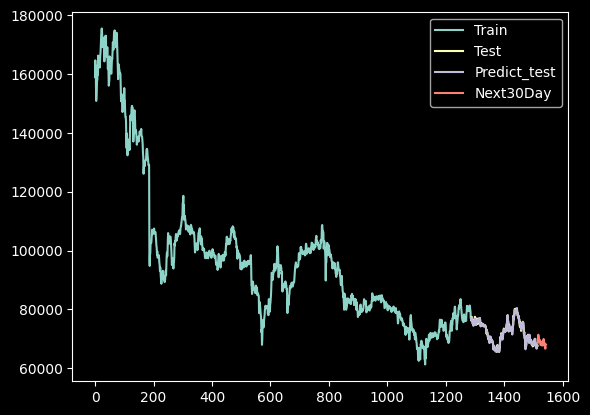

In [58]:
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predict_test','Next30Day'])
plt.show()